In [8]:
"""
This tutorial covers the following steps:
- Import data from your local machine into the Databricks File System (DBFS)
- Visualize the data using Seaborn and matplotlib
- Run a parallel hyperparameter sweep to train machine learning models on the dataset
- Explore the results of the hyperparameter sweep with MLflow
- Register the best performing model in MLflow
- Apply the registered model to another dataset using a Spark UDF
- Set up model serving for low-latency requests
"""

"""
Preparing dataset
"""


import cloudpickle
assert cloudpickle.__version__ >= "1.4.0", "Update the cloudpickle library using `%pip install --upgrade cloudpickle`"

import pandas as pd, os

# reading two datasets
white_wine = pd.read_csv(os.environ.get("WHITE_WINE_DATA_PATH"), sep=';')
red_wine = pd.read_csv(os.environ.get("RED_WINE_DATA_PATH"), sep=';')

# mark lines with color
red_wine['is_red'] = 1
white_wine['is_red'] = 0

# combine two datasets into one
data = pd.concat([red_wine, white_wine], axis=0)

# removing spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

data.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  is_red  
0      9.4        5       1  
1      9.8        5       1  
2      9.8        5       1  
3      9.8        6       1  
4      9.4        5       1

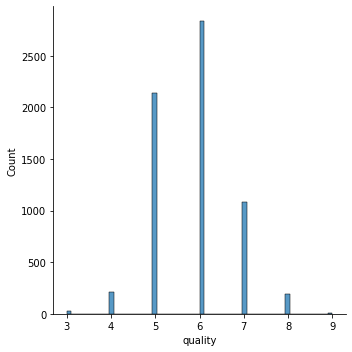

In [9]:
"""
Before training a model, explore the dataset using Seaborn and Matplotlib.
"""

import seaborn as sns

sns.displot(data.quality, kde=False)

In [10]:
"""
Define a wine as high quality if it has quality >= 7.
"""

high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

data.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  is_red  
0      9.4        0       1  
1      9.8        0       1  
2      9.8        0       1  
3      9.8        0       1  
4      9.4        0       1

'\nIn the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.\nIn the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.\n'

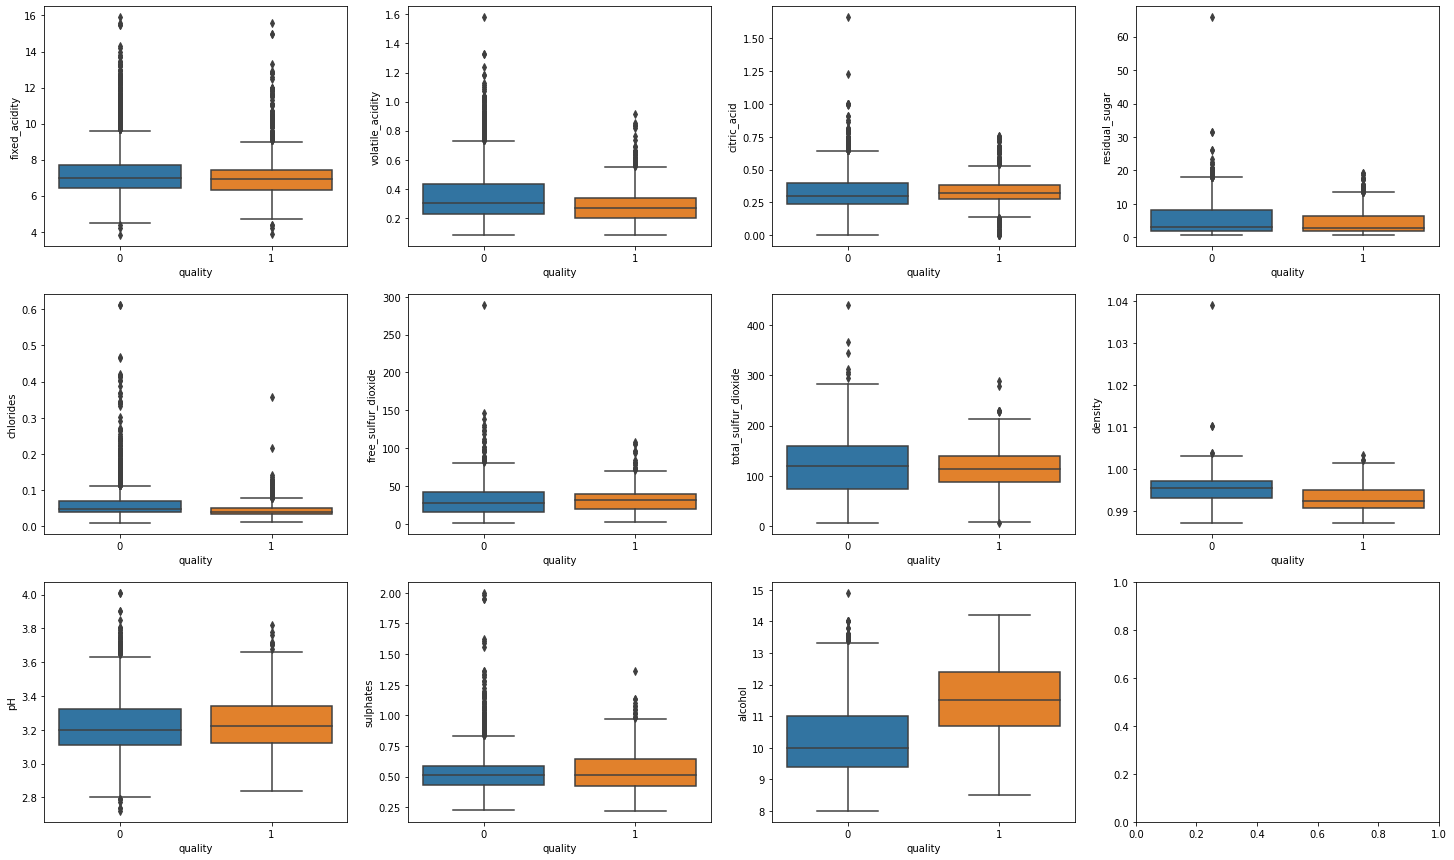

In [11]:
"""
Exploring data
"""


import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
    if col == 'is_red' or col == 'quality':
        continue  # Box plots cannot be used on indicator variables
    sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
    axis_j += 1
    if axis_j == dims[1]:
        axis_i += 1
        axis_j = 0

"""
In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.
"""

In [12]:
"""
Prior to training a model, check for missing values and split the data into training and validation sets.
"""

data.isna().any()

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=123)
X_train = train.drop(["quality"], axis=1)
X_test = test.drop(["quality"], axis=1)
y_train = train.quality
y_test = test.quality

In [13]:
"""
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model accuracy, and to save the model for later use.
"""

import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env


# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1).
# The following code creates a wrapper function, SklearnModelWrapper, that uses
# the predict_proba method to return the probability that the observation belongs to each class.

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)[:, 1]


# mlflow.start_run creates a new MLflow run to track the performance of this model.
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.

with mlflow.start_run(run_name='untuned_random_forest'):
    n_estimators = 10
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
    model.fit(X_train, y_train)

    # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
    predictions_test = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_param('n_estimators', n_estimators)
    # Use the area under the ROC curve as a metric.
    mlflow.log_metric('auc', auc_score)
    wrappedModel = SklearnModelWrapper(model)
    # Log the model with a signature that defines the schema of the model's inputs and outputs.
    # When the model is deployed, this signature will be used to validate inputs.
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))

    # MLflow contains utilities to create a conda environment used to serve models.
    # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
    conda_env = _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__),
                             "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
    mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

# defining relative features' importances
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
# sorting features by importance
feature_importances.sort_values('importance', ascending=False)

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


importance
alcohol                 0.162047
density                 0.115506
volatile_acidity        0.089138
chlorides               0.082570
pH                      0.081632
citric_acid             0.081109
total_sulfur_dioxide    0.081001
sulphates               0.078901
residual_sugar          0.077866
free_sulfur_dioxide     0.076833
fixed_acidity           0.071625
is_red                  0.001771

In [14]:
"""
Registering model in Model Registry
"""

# searching run_id for random forest run
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id


model_name = os.environ.get("MODEL_NAME")
# registering model
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

Successfully registered model 'wine_quality'.
2022/03/31 01:22:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: wine_quality, version 1
Created version '1' of model 'wine_quality'.


In [15]:
"""
Next, transition this model to production and load it into this notebook from the model registry.
"""

from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage="Production",
)

<ModelVersion: creation_timestamp=1648678927029, current_stage='Production', description='', last_updated_timestamp=1648679044315, name='wine_quality', run_id='f006648c1b894318865811ccf0e7f464', run_link='', source='./mlruns/0/f006648c1b894318865811ccf0e7f464/artifacts/random_forest_model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [16]:
"""
You can now refer to the model using the path "models:/wine-quality/production".
"""

model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

# calculating metric value on saved model
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.888902759745664


In [17]:
"""
The random forest model performed well even without hyperparameter tuning.

The following code uses the xgboost library to train a more accurate model. It runs a parallel hyperparameter sweep to train multiple
models in parallel, using Hyperopt and SparkTrials. As before, the code tracks the performance of each parameter configuration with MLflow.
"""

from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb


search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'binary:logistic',
    'seed': 123,  # Set a seed for deterministic training
}


def train_model(params):
    # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
    mlflow.xgboost.autolog()
    with mlflow.start_run(nested=True):
        train = xgb.DMatrix(data=X_train, label=y_train)
        test = xgb.DMatrix(data=X_test, label=y_test)
        # Pass in the test set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
        # is no longer improving.
        booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,
                            evals=[(test, "test")], early_stopping_rounds=50)
        predictions_test = booster.predict(test)
        auc_score = roc_auc_score(y_test, predictions_test)
        mlflow.log_metric('auc', auc_score)

        signature = infer_signature(X_train, booster.predict(train))
        mlflow.xgboost.log_model(booster, "model", signature=signature)

        # Set the loss to -1*auc_score so fmin maximizes the auc_score
        return {'status': STATUS_OK, 'loss': -1 * auc_score, 'booster': booster.attributes()}


# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep.
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = SparkTrials(parallelism=10)

# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
    best_params = fmin(
        fn=train_model,
        space=search_space,
        algo=tpe.suggest,
        max_evals=96,
        trials=spark_trials,
        rstate=np.random.default_rng(123)
    )

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/31 01:25:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


  0%|                                                                                                      | 0/96 [00:00<?, ?trial/s, best loss=?]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: Fu

[118]	test-logloss:0.33232
[1]	test-logloss:0.62350
[28]	test-logloss:0.29116
[119]	test-logloss:0.33205
[120]	test-logloss:0.33214
[121]	test-logloss:0.33209
[33]	test-logloss:0.32294
[122]	test-logloss:0.33304
[29]	test-logloss:0.29239
[2]	test-logloss:0.59594
[123]	test-logloss:0.33315
[124]	test-logloss:0.33290
[30]	test-logloss:0.29264
[125]	test-logloss:0.33276
[126]	test-logloss:0.33302
[3]	test-logloss:0.57008
[34]	test-logloss:0.32031
[127]	test-logloss:0.33275
[128]	test-logloss:0.33231
[129]	test-logloss:0.33214
[31]	test-logloss:0.29287
[130]	test-logloss:0.33133
[131]	test-logloss:0.33135
[35]	test-logloss:0.31785
[132]	test-logloss:0.33319
[4]	test-logloss:0.54687
[32]	test-logloss:0.29363
[133]	test-logloss:0.33331
[5]	test-logloss:0.52515
[36]	test-logloss:0.31569
[33]	test-logloss:0.29324
[6]	test-logloss:0.50570
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will 

[28]	test-logloss:0.31548
[59]	test-logloss:0.28960
[76]	test-logloss:0.30959
[29]	test-logloss:0.31463
[47]	test-logloss:0.34619
[33]	test-logloss:0.31126
[30]	test-logloss:0.31422
[48]	test-logloss:0.34532
[77]	test-logloss:0.31019
[01:25:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[49]	test-logloss:0.34651
[31]	test-logloss:0.31537
[0]	test-logloss:0.66294
[50]	test-logloss:0.34532
[32]	test-logloss:0.31513
[34]	test-logloss:0.30918
[51]	test-logloss:0.34663
[60]	test-logloss:0.28920
[33]	test-logloss:0.31601
[52]	test-logloss:0.34486
[34]	test-logloss:0.31534
[53]	test-logloss:0.34375
[1]	test-logloss:0.63586
[35]	test-logloss:0.31479
[54]	test-logloss:0.34210
[36]	test-logloss:0.31394
[35]	test-logloss:0.30760
[55]	test-logloss:0.34219
[37]	test-loglos

[31]	test-logloss:0.34080
[108]	test-logloss:0.31323
[23]	test-logloss:0.36756
[109]	test-logloss:0.31368
[32]	test-logloss:0.33925
[80]	test-logloss:0.28610
[57]	test-logloss:0.28667
[110]	test-logloss:0.31344
[33]	test-logloss:0.33904
[111]	test-logloss:0.31395
[24]	test-logloss:0.36266
[112]	test-logloss:0.31377
[34]	test-logloss:0.33843
[113]	test-logloss:0.31308
[81]	test-logloss:0.28598
[35]	test-logloss:0.33704
[114]	test-logloss:0.31200
[115]	test-logloss:0.31201
[36]	test-logloss:0.33673
[116]	test-logloss:0.31203
[58]	test-logloss:0.28627
[25]	test-logloss:0.35819
[37]	test-logloss:0.33584
[82]	test-logloss:0.28596
[38]	test-logloss:0.33502
[39]	test-logloss:0.33456
[26]	test-logloss:0.35426
[59]	test-logloss:0.28552
[40]	test-logloss:0.33459
[83]	test-logloss:0.28592
[41]	test-logloss:0.33444
[42]	test-logloss:0.33428
[27]	test-logloss:0.34986
[60]	test-logloss:0.28516
[43]	test-logloss:0.33414
[44]	test-logloss:0.33322
[84]	test-logloss:0.28608
[28]	test-logloss:0.34623
[45

[111]	test-logloss:0.31709
[114]	test-logloss:0.28766
[87]	test-logloss:0.28035
[112]	test-logloss:0.31695
[60]	test-logloss:0.29508
[113]	test-logloss:0.31666
[114]	test-logloss:0.31691
[88]	test-logloss:0.28034
[115]	test-logloss:0.31659
[61]	test-logloss:0.29445
[116]	test-logloss:0.31654
[117]	test-logloss:0.31589
[62]	test-logloss:0.29386
[89]	test-logloss:0.27983
[118]	test-logloss:0.31590
[119]	test-logloss:0.31609
[120]	test-logloss:0.31568
[63]	test-logloss:0.29302
[121]	test-logloss:0.31527
[90]	test-logloss:0.27946
[122]	test-logloss:0.31517
[115]	test-logloss:0.28764
[123]	test-logloss:0.31497
[91]	test-logloss:0.27939
[124]	test-logloss:0.31469
[116]	test-logloss:0.28755
[125]	test-logloss:0.31478
[64]	test-logloss:0.29278
[126]	test-logloss:0.31469
[92]	test-logloss:0.27931
[127]	test-logloss:0.31406
[117]	test-logloss:0.28767
[128]	test-logloss:0.31448
[65]	test-logloss:0.29192
[129]	test-logloss:0.31428
[93]	test-logloss:0.27953
[66]	test-logloss:0.29134
[130]	test-logl

  1%|▊                                                                          | 1/96 [00:21<33:21, 21.07s/trial, best loss: -0.8912699205318799]

[231]	test-logloss:0.30665
[109]	test-logloss:0.28226
[232]	test-logloss:0.30658
[233]	test-logloss:0.30658
[110]	test-logloss:0.28208
[120]	test-logloss:0.28103
[234]	test-logloss:0.30633
[235]	test-logloss:0.30673
[111]	test-logloss:0.28206
[236]	test-logloss:0.30692
[121]	test-logloss:0.28119
[237]	test-logloss:0.30698
[112]	test-logloss:0.28212
[238]	test-logloss:0.30720
[239]	test-logloss:0.30702
[113]	test-logloss:0.28243
[122]	test-logloss:0.28131
[240]	test-logloss:0.30719
[241]	test-logloss:0.30727[Stage 2:>    (0 + 1) / 1][Stage 3:>    (0 + 1) / 1]
[114]	test-logloss:0.28230
[242]	test-logloss:0.30697
[123]	test-logloss:0.28150
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[243]	test-logloss:0.30708
2022/03/

  2%|█▌                                                                         | 2/96 [00:25<17:17, 11.03s/trial, best loss: -0.9088018908751955]

[292]	test-logloss:0.30561
[293]	test-logloss:0.30561
[294]	test-logloss:0.30561
[295]	test-logloss:0.30528
[296]	test-logloss:0.30534
[297]	test-logloss:0.30560
[298]	test-logloss:0.30553
[299]	test-logloss:0.30544
[300]	test-logloss:0.30541
[301]	test-logloss:0.30539
[302]	test-logloss:0.30514
[303]	test-logloss:0.30537
[304]	test-logloss:0.30552
[305]	test-logloss:0.30575
[306]	test-logloss:0.30568
[307]	test-logloss:0.30575[Stage 3:>    (0 + 1) / 1][Stage 4:>    (0 + 1) / 1]
[308]	test-logloss:0.30584
[309]	test-logloss:0.30598
[310]	test-logloss:0.30592
[311]	test-logloss:0.30560
[312]	test-logloss:0.30532
[313]	test-logloss:0.30501
[314]	test-logloss:0.30504
[315]	test-logloss:0.30511
[316]	test-logloss:0.30493
[317]	test-logloss:0.30494
[318]	test-logloss:0.30506
[319]	test-logloss:0.30479
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future 

  4%|███▏                                                                       | 4/96 [00:28<07:45,  5.06s/trial, best loss: -0.9088018908751955]

[141]	test-logloss:0.29602
[142]	test-logloss:0.29648
[143]	test-logloss:0.29652
[144]	test-logloss:0.29674
[145]	test-logloss:0.29692
[146]	test-logloss:0.29701
[147]	test-logloss:0.29705
[148]	test-logloss:0.29683
[149]	test-logloss:0.29714
[150]	test-logloss:0.29669
[151]	test-logloss:0.29685                                                      
[152]	test-logloss:0.29713
[153]	test-logloss:0.29718
[154]	test-logloss:0.29728
[155]	test-logloss:0.29726
[156]	test-logloss:0.29697
[157]	test-logloss:0.29735
[158]	test-logloss:0.29714
[159]	test-logloss:0.29703
[160]	test-logloss:0.29728
[161]	test-logloss:0.29681
[162]	test-logloss:0.29663
[163]	test-logloss:0.29657
[164]	test-logloss:0.29640
[165]	test-logloss:0.29601
[166]	test-logloss:0.29615
[167]	test-logloss:0.29606
[168]	test-logloss:0.29611
[169]	test-logloss:0.29591
[170]	test-logloss:0.29601
[171]	test-logloss:0.29620
[172]	test-logloss:0.29554
[173]	test-logloss:0.29575
[174]	test-logloss:0.29612
[175]	test-logloss:0.29575
[

[01:25:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  5%|███▉                                                                       | 5/96 [00:35<08:35,  5.67s/trial, best loss: -0.9167011456535075]

[0]	test-logloss:0.51733
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:25:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer 

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:25:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at

  6%|████▋                                                                      | 6/96 [00:42<09:07,  6.08s/trial, best loss: -0.9180256143204311]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[01:26:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.44992
[1]	test-logloss:0.37554
[2]	test-logloss:0.35105
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floa

  7%|█████▍                                                                     | 7/96 [00:44<07:10,  4.84s/trial, best loss: -0.9189220679782949]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


  8%|██████▎                                                                    | 8/96 [00:46<05:50,  3.98s/trial, best loss: -0.9189220679782949]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:26:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float

  9%|███████                                                                    | 9/96 [00:51<06:13,  4.29s/trial, best loss: -0.9189220679782949]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[01:26:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.63713
[1]	test-logloss:0.59172
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2]	test-logloss:0.55521
[3]	test-logloss:0.5246

 10%|███████▋                                                                  | 10/96 [00:52<04:44,  3.30s/trial, best loss: -0.9189220679782949]

[9]	test-logloss:0.41773
[10]	test-logloss:0.40731][Stage 11:>   (0 + 1) / 1][Stage 12:>   (0 + 1) / 1]
[11]	test-logloss:0.39881
[12]	test-logloss:0.39066
[13]	test-logloss:0.38313
[14]	test-logloss:0.37691
[15]	test-logloss:0.37080
[16]	test-logloss:0.36584
[17]	test-logloss:0.36177
[18]	test-logloss:0.35795
[19]	test-logloss:0.35430
[20]	test-logloss:0.35111
[21]	test-logloss:0.34827
[22]	test-logloss:0.34560
[23]	test-logloss:0.34368
[24]	test-logloss:0.34173
[25]	test-logloss:0.33969
[26]	test-logloss:0.33753
[27]	test-logloss:0.33595
[28]	test-logloss:0.33426
[29]	test-logloss:0.33247
[30]	test-logloss:0.33106
[31]	test-logloss:0.32963
[32]	test-logloss:0.32861
[33]	test-logloss:0.32794
[34]	test-logloss:0.32726
[35]	test-logloss:0.32579
[36]	test-logloss:0.32549
[37]	test-logloss:0.32432
[38]	test-logloss:0.32369
[39]	test-logloss:0.32268
[40]	test-logloss:0.32091
[41]	test-logloss:0.32041
[42]	test-logloss:0.31949
[43]	test-logloss:0.31868
[44]	test-logloss:0.31814
[45]	test-lo

 11%|████████▍                                                                 | 11/96 [00:55<04:33,  3.22s/trial, best loss: -0.9189220679782949]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
[30]	test-logloss:0.32826
[31]	test-logloss:0.32687
[32]	test-logloss:0.32794
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: Fu

 12%|█████████▎                                                                | 12/96 [00:57<04:00,  2.86s/trial, best loss: -0.9189220679782949]

[136]	test-logloss:0.29689
[137]	test-logloss:0.29621
[138]	test-logloss:0.29624
[01:26:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.47535
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[139]	test-logloss:0.29625
[140]	test-logloss:0.29641
[01:26:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

 14%|██████████                                                                | 13/96 [01:01<04:26,  3.21s/trial, best loss: -0.9189220679782949]

[60]	test-logloss:0.39204
[1]	test-logloss:0.46862
[222]	test-logloss:0.29483
[61]	test-logloss:0.39167
[44]	test-logloss:0.36774
[2]	test-logloss:0.42649
[223]	test-logloss:0.29456
[45]	test-logloss:0.36857
[224]	test-logloss:0.29462
[3]	test-logloss:0.39976
[46]	test-logloss:0.36874
[225]	test-logloss:0.29452[Stage 14:>   (0 + 1) / 1][Stage 15:>   (0 + 1) / 1]
[47]	test-logloss:0.36873
[4]	test-logloss:0.38485
[226]	test-logloss:0.29464
[48]	test-logloss:0.37050
[5]	test-logloss:0.37407
[227]	test-logloss:0.29462
[49]	test-logloss:0.37116
[6]	test-logloss:0.36573
[228]	test-logloss:0.29465
[50]	test-logloss:0.37397
[7]	test-logloss:0.36224
[229]	test-logloss:0.29483
[51]	test-logloss:0.37550
[52]	test-logloss:0.37505
[8]	test-logloss:0.35517
[230]	test-logloss:0.29482
[53]	test-logloss:0.37463
[231]	test-logloss:0.29500
[9]	test-logloss:0.35126
[232]	test-logloss:0.29517
[10]	test-logloss:0.35017
[233]	test-logloss:0.29527
[11]	test-logloss:0.34705
[234]	test-logloss:0.29553
[54]	tes

[39]	test-logloss:0.39768
[40]	test-logloss:0.39865
[41]	test-logloss:0.39947
[42]	test-logloss:0.39796
[43]	test-logloss:0.39766
[44]	test-logloss:0.39809
[45]	test-logloss:0.39971
[46]	test-logloss:0.39999
[47]	test-logloss:0.40089
[48]	test-logloss:0.40169
[49]	test-logloss:0.40244
[50]	test-logloss:0.40317
[51]	test-logloss:0.40347
[52]	test-logloss:0.40405
[53]	test-logloss:0.40541
[96]	test-logloss:0.31591
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) wh

 15%|██████████▊                                                               | 14/96 [01:08<05:57,  4.36s/trial, best loss: -0.9189220679782949]

[1]	test-logloss:0.63845
[121]	test-logloss:0.31185
[122]	test-logloss:0.31165
[123]	test-logloss:0.31232
[2]	test-logloss:0.61445
[124]	test-logloss:0.31196
[125]	test-logloss:0.31257
[126]	test-logloss:0.31353
[3]	test-logloss:0.59293
[127]	test-logloss:0.31399
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:26:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded

[170]	test-logloss:0.28348
[171]	test-logloss:0.28335
[172]	test-logloss:0.28312
[173]	test-logloss:0.28331
[174]	test-logloss:0.28321
[175]	test-logloss:0.28347
[176]	test-logloss:0.28356
[177]	test-logloss:0.28365
[178]	test-logloss:0.28369
[179]	test-logloss:0.28357
[180]	test-logloss:0.28368
[181]	test-logloss:0.28349
[182]	test-logloss:0.28355
[183]	test-logloss:0.28346
[184]	test-logloss:0.28346
[185]	test-logloss:0.28372
[186]	test-logloss:0.28377
[187]	test-logloss:0.28385
[188]	test-logloss:0.28380
[189]	test-logloss:0.28377
[190]	test-logloss:0.28388
[191]	test-logloss:0.28403
[192]	test-logloss:0.28420
[193]	test-logloss:0.28434
[194]	test-logloss:0.28425
[195]	test-logloss:0.28420
[196]	test-logloss:0.28417
[197]	test-logloss:0.28420
[198]	test-logloss:0.28439
[199]	test-logloss:0.28450
[200]	test-logloss:0.28476
[201]	test-logloss:0.28471
[202]	test-logloss:0.28472
[203]	test-logloss:0.28467
[204]	test-logloss:0.28482
[205]	test-logloss:0.28492
[206]	test-logloss:0.28499
[

 16%|███████████▌                                                              | 15/96 [01:17<07:46,  5.76s/trial, best loss: -0.9189220679782949]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:26:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float

 17%|████████████▎                                                             | 16/96 [01:26<08:59,  6.74s/trial, best loss: -0.9189220679782949]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


 18%|█████████████                                                             | 17/96 [01:29<07:24,  5.63s/trial, best loss: -0.9189220679782949]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:26:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float

 20%|██████████████▋                                                           | 19/96 [01:37<06:16,  4.89s/trial, best loss: -0.9189220679782949]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in

[210]	test-logloss:0.28414
[211]	test-logloss:0.28445
[212]	test-logloss:0.28434
[213]	test-logloss:0.28443
[214]	test-logloss:0.28448
[215]	test-logloss:0.28434
[216]	test-logloss:0.28438
[1]	test-logloss:0.59884
[2]	test-logloss:0.56283
[3]	test-logloss:0.53113
[4]	test-logloss:0.50294
[5]	test-logloss:0.47795
[6]	test-logloss:0.45748
[7]	test-logloss:0.43975
[8]	test-logloss:0.42273
[9]	test-logloss:0.40766
[10]	test-logloss:0.39443
[11]	test-logloss:0.38255
[12]	test-logloss:0.37192
[13]	test-logloss:0.36380
[14]	test-logloss:0.35541
[15]	test-logloss:0.34861
[16]	test-logloss:0.34161
[17]	test-logloss:0.33670
[18]	test-logloss:0.33172
[19]	test-logloss:0.32668
[20]	test-logloss:0.32244
[21]	test-logloss:0.31826
[22]	test-logloss:0.31487
[23]	test-logloss:0.31102
[24]	test-logloss:0.30800
[25]	test-logloss:0.30559
[26]	test-logloss:0.30377
[27]	test-logloss:0.30142
[28]	test-logloss:0.29931
[29]	test-logloss:0.29695
[30]	test-logloss:0.29584
[31]	test-logloss:0.29370
[32]	test-logl

 21%|███████████████▍                                                          | 20/96 [01:45<07:10,  5.67s/trial, best loss: -0.9189220679782949]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[01:27:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.58124
[01:27:05] WARNING: /Users/runner/work/xgboost/xgboos

 22%|████████████████▏                                                         | 21/96 [01:47<05:53,  4.72s/trial, best loss: -0.9189220679782949]

[2]	test-logloss:0.60398
[19]	test-logloss:0.30923
[20]	test-logloss:0.30816
[3]	test-logloss:0.57965
[21]	test-logloss:0.30704
[22]	test-logloss:0.30788
[23]	test-logloss:0.30716
[4]	test-logloss:0.55806
[24]	test-logloss:0.30601
[25]	test-logloss:0.30427
[5]	test-logloss:0.53910
[26]	test-logloss:0.30411
[27]	test-logloss:0.30342
[6]	test-logloss:0.52147
[28]	test-logloss:0.30208][Stage 22:>   (0 + 1) / 1][Stage 23:>   (0 + 1) / 1]
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:27:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred 

 23%|████████████████▉                                                         | 22/96 [01:50<05:14,  4.26s/trial, best loss: -0.9189220679782949]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[28]	test-logloss:0.33706
[01:27:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.65564
[29]	test-logloss:0.33365
[76]	test-logloss:0.29754
[77]	test-logloss:0.29750
[30]	test-logloss:0.33008
[1]	test-logloss:0.62362
[78]	test-logloss:0.29753
[79]	test-logloss:0.29661][Stage 23:>   (0 + 1) / 1][Stage 24:>   (0 + 1) / 1]
[80]	test-logloss:0.29707
[31]	test-logloss:0.32705
[2]	test-logloss:0.59379
[81]	test-logloss:0.29757
[82]	test

[34]	test-logloss:0.39732
[35]	test-logloss:0.40045
[76]	test-logloss:0.29317
[36]	test-logloss:0.39931
[37]	test-logloss:0.31131
[37]	test-logloss:0.40037


 24%|█████████████████▋                                                        | 23/96 [01:54<05:05,  4.19s/trial, best loss: -0.9189220679782949]

[38]	test-logloss:0.40137
[77]	test-logloss:0.29356
[39]	test-logloss:0.40261
[40]	test-logloss:0.40426
[38]	test-logloss:0.30999
[41]	test-logloss:0.40509
[78]	test-logloss:0.29384
[42]	test-logloss:0.40676
[43]	test-logloss:0.40751
[44]	test-logloss:0.40737
[39]	test-logloss:0.30889
[45]	test-logloss:0.40687
[79]	test-logloss:0.29421][Stage 24:>   (0 + 1) / 1][Stage 25:>   (0 + 1) / 1]
[46]	test-logloss:0.40629
[47]	test-logloss:0.40339
[48]	test-logloss:0.40276
[40]	test-logloss:0.30828
[49]	test-logloss:0.40273
[80]	test-logloss:0.29446
[50]	test-logloss:0.40558
[51]	test-logloss:0.40558
[52]	test-logloss:0.40701
[53]	test-logloss:0.40708
[81]	test-logloss:0.29446
[41]	test-logloss:0.30766
[54]	test-logloss:0.40824
[55]	test-logloss:0.40918
[56]	test-logloss:0.40914
[82]	test-logloss:0.29488
[42]	test-logloss:0.30685
[83]	test-logloss:0.29500
[43]	test-logloss:0.30623
[84]	test-logloss:0.29492
[44]	test-logloss:0.30576
[85]	test-logloss:0.29495
[45]	test-logloss:0.30565
[86]	test-l

 25%|██████████████████▌                                                       | 24/96 [01:58<04:58,  4.14s/trial, best loss: -0.9189220679782949]

[97]	test-logloss:0.31283
[40]	test-logloss:0.29178
[41]	test-logloss:0.29141
[98]	test-logloss:0.31300
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[42]	test-logloss:0.29240                                                       
[01:27:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[43]	test-logloss:0.29270
[0]	test-logloss:0.64165
[99]	test-logloss:0.31314
[1]	test-logloss:0.59799
[100]	test-logloss:0.31345
[2]	test-logloss:0.56048
[3]	test-logloss:0.52975
[101]	test-logloss:0.31382
[4]	te

 26%|███████████████████▎                                                      | 25/96 [01:59<03:49,  3.24s/trial, best loss: -0.9189220679782949]

[46]	test-logloss:0.29226
[12]	test-logloss:0.38764
[47]	test-logloss:0.29262
[13]	test-logloss:0.38074
[48]	test-logloss:0.29351
[14]	test-logloss:0.37349
[49]	test-logloss:0.29401
[15]	test-logloss:0.36731
[50]	test-logloss:0.29384
[16]	test-logloss:0.36240
[51]	test-logloss:0.29474
[17]	test-logloss:0.35679
[52]	test-logloss:0.29503
[18]	test-logloss:0.35274
[53]	test-logloss:0.29414
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:27:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer colum

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:27:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contai

 27%|████████████████████                                                      | 26/96 [02:03<04:02,  3.47s/trial, best loss: -0.9189220679782949]

[1]	test-logloss:0.63486
[2]	test-logloss:0.61062
[3]	test-logloss:0.58850
[4]	test-logloss:0.56936
[5]	test-logloss:0.55202
[6]	test-logloss:0.53631                                                        
[7]	test-logloss:0.52227
[8]	test-logloss:0.50952
[9]	test-logloss:0.49781
[10]	test-logloss:0.48716
[11]	test-logloss:0.47740
[12]	test-logloss:0.46817
[13]	test-logloss:0.46021
[14]	test-logloss:0.45311
[15]	test-logloss:0.44624
[16]	test-logloss:0.44002
[17]	test-logloss:0.43445
[18]	test-logloss:0.42883
[19]	test-logloss:0.42378
[20]	test-logloss:0.41946
[21]	test-logloss:0.41491
[22]	test-logloss:0.41104
[23]	test-logloss:0.40711
[24]	test-logloss:0.40404
[25]	test-logloss:0.40082
[26]	test-logloss:0.39782
[27]	test-logloss:0.39491
[28]	test-logloss:0.39250
[29]	test-logloss:0.39006
[30]	test-logloss:0.38778
[31]	test-logloss:0.38549
[32]	test-logloss:0.38354
[33]	test-logloss:0.38119
[34]	test-logloss:0.37952
[35]	test-logloss:0.37789
[36]	test-logloss:0.37635
[37]	test-logloss

[78]	test-logloss:0.28006
[79]	test-logloss:0.28020
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:27:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternativel

 28%|████████████████████▊                                                     | 27/96 [02:08<04:31,  3.93s/trial, best loss: -0.9189220679782949]

[275]	test-logloss:0.31252
[105]	test-logloss:0.28383
[276]	test-logloss:0.31256
[277]	test-logloss:0.31269
[278]	test-logloss:0.31277
[279]	test-logloss:0.31273
[106]	test-logloss:0.28363
[280]	test-logloss:0.31269
[281]	test-logloss:0.31251
[107]	test-logloss:0.28373
[282]	test-logloss:0.31253
[283]	test-logloss:0.31211
[284]	test-logloss:0.31214
[108]	test-logloss:0.28414
[285]	test-logloss:0.31188
[286]	test-logloss:0.31188
[287]	test-logloss:0.31182
[288]	test-logloss:0.31152
[289]	test-logloss:0.31135
[290]	test-logloss:0.31144
[291]	test-logloss:0.31136
[292]	test-logloss:0.31150
[293]	test-logloss:0.31148
[294]	test-logloss:0.31147
[295]	test-logloss:0.31126
[296]	test-logloss:0.31062
[297]	test-logloss:0.31046
[298]	test-logloss:0.31051
[299]	test-logloss:0.31032
[300]	test-logloss:0.31034
[301]	test-logloss:0.31041
[302]	test-logloss:0.31022
[303]	test-logloss:0.31010
[304]	test-logloss:0.31018
[305]	test-logloss:0.31013
[306]	test-logloss:0.30987
[307]	test-logloss:0.30980
[

[632]	test-logloss:0.29191
[633]	test-logloss:0.29188
[634]	test-logloss:0.29182
[635]	test-logloss:0.29187
[1]	test-logloss:0.64065
[636]	test-logloss:0.29205
[637]	test-logloss:0.29202
[638]	test-logloss:0.29197
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inpu

[841]	test-logloss:0.28728
[842]	test-logloss:0.28749
[36]	test-logloss:0.34080
[843]	test-logloss:0.28755
[844]	test-logloss:0.28755
[845]	test-logloss:0.28746
[846]	test-logloss:0.28752
[847]	test-logloss:0.28758
[37]	test-logloss:0.33841
[848]	test-logloss:0.28769
[849]	test-logloss:0.28771
[850]	test-logloss:0.28768
[851]	test-logloss:0.28776
[38]	test-logloss:0.33566
[852]	test-logloss:0.28772
[853]	test-logloss:0.28771
[854]	test-logloss:0.28758
[855]	test-logloss:0.28752[39]	test-logloss:0.33329

[856]	test-logloss:0.28776
[857]	test-logloss:0.28779
[858]	test-logloss:0.28789
[40]	test-logloss:0.33108
[859]	test-logloss:0.28780
[860]	test-logloss:0.28796
[861]	test-logloss:0.28803
[862]	test-logloss:0.28801
[41]	test-logloss:0.32867
[863]	test-logloss:0.28802
[864]	test-logloss:0.28786
[865]	test-logloss:0.28791
[866]	test-logloss:0.28806
[42]	test-logloss:0.32668
[43]	test-logloss:0.32458
[44]	test-logloss:0.32321
[45]	test-logloss:0.32145
[46]	test-logloss:0.32020
[47]	test-lo

 29%|█████████████████████▌                                                    | 28/96 [02:13<04:49,  4.26s/trial, best loss: -0.9189220679782949]

[67]	test-logloss:0.29788
[68]	test-logloss:0.29711
[69]	test-logloss:0.29606
[70]	test-logloss:0.29570
[71]	test-logloss:0.29486
[72]	test-logloss:0.29444
[73]	test-logloss:0.29389
[74]	test-logloss:0.29339
[75]	test-logloss:0.29343
[76]	test-logloss:0.29325
[77]	test-logloss:0.29305
[78]	test-logloss:0.29288
[79]	test-logloss:0.29228
[80]	test-logloss:0.29163
[81]	test-logloss:0.29115
[82]	test-logloss:0.29089
[83]	test-logloss:0.29064
[84]	test-logloss:0.29020
[85]	test-logloss:0.28964
[86]	test-logloss:0.28938
[87]	test-logloss:0.28867
[88]	test-logloss:0.28818
[89]	test-logloss:0.28804
[90]	test-logloss:0.28788
[91]	test-logloss:0.28747
[92]	test-logloss:0.28713
[93]	test-logloss:0.28696
[94]	test-logloss:0.28674
[95]	test-logloss:0.28672
[96]	test-logloss:0.28648
[97]	test-logloss:0.28613
[98]	test-logloss:0.28583
[99]	test-logloss:0.28580
[100]	test-logloss:0.28573
[101]	test-logloss:0.28576
[102]	test-logloss:0.28560
[103]	test-logloss:0.28545[Stage 29:>   (0 + 1) / 1][Stage 30

 30%|██████████████████████▎                                                   | 29/96 [02:14<03:40,  3.29s/trial, best loss: -0.9189220679782949]

[01:27:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.62035
[1]	test-logloss:0.56406
[2]	test-logloss:0.51870
[3]	test-logloss:0.48051
[4]	test-logloss:0.45123
[5]	test-logloss:0.42715
[6]	test-logloss:0.40581
[7]	test-logloss:0.38702
[8]	test-logloss:0.37110
[9]	test-logloss:0.35724
[10]	test-logloss:0.34688][Stage 30:>   (0 + 1) / 1][Stage 31:>   (0 + 1) / 1]
[11]	test-logloss:0.33796
[111]	test-logloss:0.28525
[12]	test-logloss:0.33032
[112]	test-logloss:0.28493
[13]	test-logloss:0.32400
[113]	test-logloss:0.28476
[114]	test-logloss:0.28452
[14]	test-logloss:0.31836
[115]	test-logloss:0.28436
[15]	test-logloss:0.31353
[116]	test-logloss:0.28369
[16]	test-logloss:0.31092
[117]	test-logloss:0.28347
[118]	test-logloss:0.28311
[17]	test-loglo

 31%|███████████████████████▏                                                  | 30/96 [02:16<03:12,  2.92s/trial, best loss: -0.9199469261388766]

[132]	test-logloss:0.28156
[27]	test-logloss:0.29150
[133]	test-logloss:0.28181
[134]	test-logloss:0.28180
[135]	test-logloss:0.28183
[28]	test-logloss:0.29114
[136]	test-logloss:0.28188
[137]	test-logloss:0.28182
[29]	test-logloss:0.29100
[138]	test-logloss:0.28174
[30]	test-logloss:0.29119
[139]	test-logloss:0.28176
[140]	test-logloss:0.28178
[31]	test-logloss:0.29112
[141]	test-logloss:0.28172[Stage 31:>   (0 + 1) / 1][Stage 32:>   (0 + 1) / 1]
[32]	test-logloss:0.29159
[142]	test-logloss:0.28171
[33]	test-logloss:0.29143
[143]	test-logloss:0.28178
[144]	test-logloss:0.28180
[34]	test-logloss:0.29169
[145]	test-logloss:0.28165
[35]	test-logloss:0.29083
[146]	test-logloss:0.28196
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[147]	test

 32%|███████████████████████▉                                                  | 31/96 [02:19<03:11,  2.95s/trial, best loss: -0.9199469261388766]

[4]	test-logloss:0.52014
[179]	test-logloss:0.28223
[5]	test-logloss:0.49768
[15]	test-logloss:0.29800
[180]	test-logloss:0.28254[Stage 32:>   (0 + 1) / 1][Stage 33:>   (0 + 1) / 1]
[55]	test-logloss:0.29388
[16]	test-logloss:0.29641
[17]	test-logloss:0.29563
[181]	test-logloss:0.28247
[6]	test-logloss:0.47962
[56]	test-logloss:0.29466
[18]	test-logloss:0.29309
[7]	test-logloss:0.46361
[182]	test-logloss:0.28237
[57]	test-logloss:0.29459
[8]	test-logloss:0.45024
[19]	test-logloss:0.29176
[9]	test-logloss:0.43847
[20]	test-logloss:0.29126
[58]	test-logloss:0.29511
[21]	test-logloss:0.29008
[10]	test-logloss:0.42819
[22]	test-logloss:0.28851
[11]	test-logloss:0.41858
[59]	test-logloss:0.29533
[23]	test-logloss:0.28790
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas impor

 33%|████████████████████████▋                                                 | 32/96 [02:22<03:10,  2.97s/trial, best loss: -0.9199469261388766]

[14]	test-logloss:0.34067
[79]	test-logloss:0.28800
[80]	test-logloss:0.28806
[15]	test-logloss:0.33356
[81]	test-logloss:0.28903
[55]	test-logloss:0.32111
[82]	test-logloss:0.28893
[56]	test-logloss:0.32037
[57]	test-logloss:0.32000
[16]	test-logloss:0.32812
[58]	test-logloss:0.31943][Stage 33:>   (0 + 1) / 1][Stage 34:>   (0 + 1) / 1]
[17]	test-logloss:0.32259
[59]	test-logloss:0.31940
[60]	test-logloss:0.31822
[18]	test-logloss:0.31867
[61]	test-logloss:0.31785
[62]	test-logloss:0.31719
[19]	test-logloss:0.31430
[63]	test-logloss:0.31677
[64]	test-logloss:0.31619
[20]	test-logloss:0.31148
[83]	test-logloss:0.29061
[65]	test-logloss:0.31599
[84]	test-logloss:0.29100
[66]	test-logloss:0.31638
[21]	test-logloss:0.30832
[85]	test-logloss:0.29165
[67]	test-logloss:0.31575
[86]	test-logloss:0.29218
[87]	test-logloss:0.29222
[68]	test-logloss:0.31539
[88]	test-logloss:0.29240
[69]	test-logloss:0.31508
[89]	test-logloss:0.29243
[22]	test-logloss:0.30412
/Users/Ivan_Sheviakov/m08_sparkml_pyt

[59]	test-logloss:0.28054
[132]	test-logloss:0.30248
[51]	test-logloss:0.33839
[1]	test-logloss:0.47844
[133]	test-logloss:0.30271
[60]	test-logloss:0.28113
[134]	test-logloss:0.30236
[52]	test-logloss:0.33746
[2]	test-logloss:0.42645
[135]	test-logloss:0.30257
[61]	test-logloss:0.28133
[53]	test-logloss:0.33654
[3]	test-logloss:0.39529
[136]	test-logloss:0.30251
[54]	test-logloss:0.33564
[62]	test-logloss:0.28149
[137]	test-logloss:0.30216
[55]	test-logloss:0.33475
[138]	test-logloss:0.30152
[63]	test-logloss:0.28151
[56]	test-logloss:0.33406
[139]	test-logloss:0.30124
[64]	test-logloss:0.28150
[140]	test-logloss:0.30127
[57]	test-logloss:0.33338
[65]	test-logloss:0.28138
[141]	test-logloss:0.30085
[58]	test-logloss:0.33253
[142]	test-logloss:0.30056
[59]	test-logloss:0.33174
[66]	test-logloss:0.28159
[143]	test-logloss:0.30065
[60]	test-logloss:0.33094
[67]	test-logloss:0.28221
[144]	test-logloss:0.30046
[145]	test-logloss:0.30039
[61]	test-logloss:0.33004
[68]	test-logloss:0.28225
[

[214]	test-logloss:0.29567
[42]	test-logloss:0.30720
[105]	test-logloss:0.30844
[215]	test-logloss:0.29567
[43]	test-logloss:0.30797
[106]	test-logloss:0.30830
[216]	test-logloss:0.29591
[44]	test-logloss:0.30778
[107]	test-logloss:0.30817
[217]	test-logloss:0.29572
[45]	test-logloss:0.30809
[46]	test-logloss:0.30783
[108]	test-logloss:0.30761
[47]	test-logloss:0.30748
[109]	test-logloss:0.30735
[48]	test-logloss:0.30830
[110]	test-logloss:0.30721
[49]	test-logloss:0.30734
[111]	test-logloss:0.30699
[50]	test-logloss:0.30920
[112]	test-logloss:0.30674
[51]	test-logloss:0.30938
[113]	test-logloss:0.30643
[52]	test-logloss:0.30961
[114]	test-logloss:0.30618
[53]	test-logloss:0.30998
[54]	test-logloss:0.31047
[115]	test-logloss:0.30586
[55]	test-logloss:0.31059
[116]	test-logloss:0.30575
[56]	test-logloss:0.30997
[117]	test-logloss:0.30541
[57]	test-logloss:0.30968
[118]	test-logloss:0.30529
[58]	test-logloss:0.31004
[119]	test-logloss:0.30490
[59]	test-logloss:0.30941
[120]	test-logloss:

 35%|██████████████████████████▏                                               | 34/96 [02:32<04:02,  3.91s/trial, best loss: -0.9199469261388766]

[148]	test-logloss:0.29900
[149]	test-logloss:0.29858
[150]	test-logloss:0.29853
[151]	test-logloss:0.29851[Stage 35:>   (0 + 1) / 1][Stage 36:>   (0 + 1) / 1]
[152]	test-logloss:0.29826
[153]	test-logloss:0.29811
[154]	test-logloss:0.29791
[155]	test-logloss:0.29790
[156]	test-logloss:0.29773
[157]	test-logloss:0.29753
[158]	test-logloss:0.29724
[159]	test-logloss:0.29712
[160]	test-logloss:0.29717
[161]	test-logloss:0.29677
[162]	test-logloss:0.29660
[163]	test-logloss:0.29654
[164]	test-logloss:0.29656
[165]	test-logloss:0.29660
[166]	test-logloss:0.29679
[167]	test-logloss:0.29693
[168]	test-logloss:0.29684
[169]	test-logloss:0.29682
[170]	test-logloss:0.29701
[171]	test-logloss:0.29687
[172]	test-logloss:0.29676
[173]	test-logloss:0.29662
[174]	test-logloss:0.29659
[175]	test-logloss:0.29640
[176]	test-logloss:0.29603
[177]	test-logloss:0.29596
[178]	test-logloss:0.29582
[179]	test-logloss:0.29587
[180]	test-logloss:0.29593
[181]	test-logloss:0.29586
[182]	test-logloss:0.29592
[18

 36%|██████████████████████████▉                                               | 35/96 [02:34<03:30,  3.45s/trial, best loss: -0.9199469261388766]

[273]	test-logloss:0.29164
[274]	test-logloss:0.29149
[275]	test-logloss:0.29153
[276]	test-logloss:0.29135
[277]	test-logloss:0.29120
[278]	test-logloss:0.29107
[279]	test-logloss:0.29097
[280]	test-logloss:0.29095
[281]	test-logloss:0.29100
[282]	test-logloss:0.29107
[283]	test-logloss:0.29109
[284]	test-logloss:0.29113
[285]	test-logloss:0.29116
[286]	test-logloss:0.29116
[287]	test-logloss:0.29101
[288]	test-logloss:0.29110
[289]	test-logloss:0.29094
[290]	test-logloss:0.29082
[291]	test-logloss:0.29078
[292]	test-logloss:0.29095
[293]	test-logloss:0.29100
[294]	test-logloss:0.29096
[295]	test-logloss:0.29089
[296]	test-logloss:0.29103
[297]	test-logloss:0.29095
[298]	test-logloss:0.29088
[299]	test-logloss:0.29098
[300]	test-logloss:0.29105
[301]	test-logloss:0.29109
[302]	test-logloss:0.29091
[303]	test-logloss:0.29072
[304]	test-logloss:0.29074
[305]	test-logloss:0.29060
[306]	test-logloss:0.29072
[307]	test-logloss:0.29077
[308]	test-logloss:0.29074
[309]	test-logloss:0.29057
[

 38%|███████████████████████████▊                                              | 36/96 [02:36<03:04,  3.08s/trial, best loss: -0.9199469261388766]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[01:27:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:27:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: St

[5]	test-logloss:0.33786
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:27:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer 

 39%|████████████████████████████▌                                             | 37/96 [02:44<04:20,  4.42s/trial, best loss: -0.9199469261388766]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:28:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float

 41%|██████████████████████████████                                            | 39/96 [02:47<02:59,  3.15s/trial, best loss: -0.9199469261388766]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas i

[1]	test-logloss:0.43386
[1]	test-logloss:0.46259
[2]	test-logloss:0.39484
[3]	test-logloss:0.37185
[2]	test-logloss:0.41159
[4]	test-logloss:0.35958
[5]	test-logloss:0.35176
[3]	test-logloss:0.37597
[6]	test-logloss:0.34438
[7]	test-logloss:0.33814
[4]	test-logloss:0.35312
[8]	test-logloss:0.33329
[9]	test-logloss:0.33168
[5]	test-logloss:0.33859
[10]	test-logloss:0.32899
[11]	test-logloss:0.32877
[6]	test-logloss:0.33172
[12]	test-logloss:0.32797
[7]	test-logloss:0.32562
[13]	test-logloss:0.32755
[14]	test-logloss:0.32633
[8]	test-logloss:0.32071
[15]	test-logloss:0.32245
[16]	test-logloss:0.32040
[9]	test-logloss:0.31749
[17]	test-logloss:0.31768
[18]	test-logloss:0.31538
[19]	test-logloss:0.31655
[10]	test-logloss:0.31371
[20]	test-logloss:0.31592
[21]	test-logloss:0.31600
[11]	test-logloss:0.31340
[22]	test-logloss:0.31576
[23]	test-logloss:0.31439
[12]	test-logloss:0.31592
[24]	test-logloss:0.31648
[25]	test-logloss:0.31484
[13]	test-logloss:0.31459
[26]	test-logloss:0.31504
[27]

 42%|██████████████████████████████▊                                           | 40/96 [02:57<04:28,  4.80s/trial, best loss: -0.9199469261388766]

 44%|████████████████████████████████▍                                         | 42/96 [02:59<02:45,  3.06s/trial, best loss: -0.9199469261388766]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:28:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float

 45%|█████████████████████████████████▏                                        | 43/96 [03:04<03:06,  3.51s/trial, best loss: -0.9199469261388766]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[01:28:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Startin

 46%|█████████████████████████████████▉                                        | 44/96 [03:05<02:31,  2.91s/trial, best loss: -0.9199469261388766]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[1]	test-logloss:0.42852
[2]	test-logloss:0.38531
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[01:28:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.59549
[3]

[1]	test-logloss:0.57132
[2]	test-logloss:0.52875
[27]	test-logloss:0.30954
[3]	test-logloss:0.49227
[53]	test-logloss:0.34899
[28]	test-logloss:0.30888
[4]	test-logloss:0.46387
[54]	test-logloss:0.34869
[55]	test-logloss:0.34914
[5]	test-logloss:0.43771
[29]	test-logloss:0.30977
[56]	test-logloss:0.35001
[57]	test-logloss:0.35082
[6]	test-logloss:0.41463
[30]	test-logloss:0.30947
[58]	test-logloss:0.35188
[59]	test-logloss:0.35252
[31]	test-logloss:0.31142
[7]	test-logloss:0.39662
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[60]	test-logloss:0.35296
[61]	test-logloss:0.35390
[32]	test-logloss:0.31183
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: 

 48%|███████████████████████████████████▍                                      | 46/96 [03:12<02:37,  3.16s/trial, best loss: -0.9199469261388766]

[37]	test-logloss:0.28184
[38]	test-logloss:0.28170
[39]	test-logloss:0.28164
[40]	test-logloss:0.28148
[41]	test-logloss:0.28177
[42]	test-logloss:0.28164
[43]	test-logloss:0.28174
[44]	test-logloss:0.28129
[45]	test-logloss:0.28148
[46]	test-logloss:0.28181
[47]	test-logloss:0.28162
[48]	test-logloss:0.28216
[49]	test-logloss:0.28229
[50]	test-logloss:0.28282
[51]	test-logloss:0.28243
[52]	test-logloss:0.28306
[53]	test-logloss:0.28338
[54]	test-logloss:0.28372
[55]	test-logloss:0.28392
[56]	test-logloss:0.28397
[57]	test-logloss:0.28394
[58]	test-logloss:0.28458
[59]	test-logloss:0.28479
[60]	test-logloss:0.28453
[61]	test-logloss:0.28452
[62]	test-logloss:0.28472


 49%|████████████████████████████████████▏                                     | 47/96 [03:13<02:10,  2.67s/trial, best loss: -0.9199469261388766]

[63]	test-logloss:0.28527][Stage 48:>   (0 + 1) / 1][Stage 49:>   (0 + 1) / 1]
[64]	test-logloss:0.28496
[65]	test-logloss:0.28510
[66]	test-logloss:0.28552
[67]	test-logloss:0.28577
[68]	test-logloss:0.28610
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[69]	test-logloss:0.28602
2022/03/31 01:28:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a s

[13]	test-logloss:0.33680
[9]	test-logloss:0.32564
[14]	test-logloss:0.33491
[10]	test-logloss:0.32230
[15]	test-logloss:0.33526
[16]	test-logloss:0.33374
[11]	test-logloss:0.31612
[0]	test-logloss:0.64870
[12]	test-logloss:0.31385
[1]	test-logloss:0.61060
[17]	test-logloss:0.33166
[18]	test-logloss:0.33072
[2]	test-logloss:0.57882
[19]	test-logloss:0.32898
[13]	test-logloss:0.31270
[20]	test-logloss:0.32812
[3]	test-logloss:0.54977
[21]	test-logloss:0.32755
[14]	test-logloss:0.31009
[22]	test-logloss:0.32608
[4]	test-logloss:0.52514
[15]	test-logloss:0.31083
[23]	test-logloss:0.32508
[16]	test-logloss:0.31222
[5]	test-logloss:0.50287
[24]	test-logloss:0.32520
[25]	test-logloss:0.32507
[17]	test-logloss:0.31120
[26]	test-logloss:0.32443
[6]	test-logloss:0.48259
[27]	test-logloss:0.32339
[18]	test-logloss:0.30960
[7]	test-logloss:0.46427
[28]	test-logloss:0.32238
[19]	test-logloss:0.30861
[29]	test-logloss:0.32269
[8]	test-logloss:0.44840
[30]	test-logloss:0.32156
[20]	test-logloss:0.30

 50%|█████████████████████████████████████                                     | 48/96 [03:22<03:23,  4.23s/trial, best loss: -0.9199469261388766]

[132]	test-logloss:0.30683[Stage 49:>   (0 + 1) / 1][Stage 50:>   (0 + 1) / 1]
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:28:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes m

 51%|█████████████████████████████████████▊                                    | 49/96 [03:24<02:52,  3.66s/trial, best loss: -0.9199469261388766]

[127]	test-logloss:0.28379                                                      
[128]	test-logloss:0.28379
[129]	test-logloss:0.28377
[130]	test-logloss:0.28395
[131]	test-logloss:0.28417[Stage 50:>   (0 + 1) / 1][Stage 51:>   (0 + 1) / 1]
[132]	test-logloss:0.28419
[133]	test-logloss:0.28420
[134]	test-logloss:0.28409
[135]	test-logloss:0.28430
[136]	test-logloss:0.28406
[137]	test-logloss:0.28389
[138]	test-logloss:0.28384
[139]	test-logloss:0.28396
[140]	test-logloss:0.28371
[141]	test-logloss:0.28348
[142]	test-logloss:0.28363
[143]	test-logloss:0.28350
[144]	test-logloss:0.28398
[145]	test-logloss:0.28404
[146]	test-logloss:0.28450
[147]	test-logloss:0.28410
[148]	test-logloss:0.28431
[149]	test-logloss:0.28412
[150]	test-logloss:0.28428
[151]	test-logloss:0.28438
[152]	test-logloss:0.28452
[153]	test-logloss:0.28490
[154]	test-logloss:0.28480
[155]	test-logloss:0.28473
[156]	test-logloss:0.28467
[157]	test-logloss:0.28474
[158]	test-logloss:0.28472
[159]	test-logloss:0.28467
[16

 53%|███████████████████████████████████████▎                                  | 51/96 [03:28<02:13,  2.96s/trial, best loss: -0.9199469261388766]

[0]	test-logloss:0.593901][Stage 52:>   (0 + 1) / 1][Stage 53:>   (0 + 1) / 1]
[1]	test-logloss:0.52488
[2]	test-logloss:0.47815
[3]	test-logloss:0.44314
[4]	test-logloss:0.41708
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[5]	test-logloss:0.39570
[6]	test-logloss:0.38130
[7]	test-logloss:0.37037
[8]	test-logloss:0.36087
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:28:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "

 54%|████████████████████████████████████████                                  | 52/96 [03:31<02:11,  2.98s/trial, best loss: -0.9199469261388766]

[7]	test-logloss:0.36725
[8]	test-logloss:0.35319
[9]	test-logloss:0.34419
[10]	test-logloss:0.33556
[11]	test-logloss:0.32750
[12]	test-logloss:0.32127
[13]	test-logloss:0.31479][Stage 53:>   (0 + 1) / 1][Stage 54:>   (0 + 1) / 1]
[14]	test-logloss:0.30977
[15]	test-logloss:0.30544
[16]	test-logloss:0.30261
[17]	test-logloss:0.30031
[18]	test-logloss:0.29785
[19]	test-logloss:0.29507
[20]	test-logloss:0.29284
[21]	test-logloss:0.29056
[22]	test-logloss:0.29061
[23]	test-logloss:0.28932
[24]	test-logloss:0.28861
[25]	test-logloss:0.28933
[26]	test-logloss:0.28889
[27]	test-logloss:0.28944
[28]	test-logloss:0.29092
[29]	test-logloss:0.29119
[30]	test-logloss:0.29164
[31]	test-logloss:0.29172
[32]	test-logloss:0.29100
[33]	test-logloss:0.29116
[34]	test-logloss:0.29207
[35]	test-logloss:0.29253
[36]	test-logloss:0.29269
[37]	test-logloss:0.29281
[38]	test-logloss:0.29303
[39]	test-logloss:0.29268
[40]	test-logloss:0.29296
[41]	test-logloss:0.29268
[42]	test-logloss:0.29229
[43]	test-logl

[40]	test-logloss:0.33787
[41]	test-logloss:0.33937
[42]	test-logloss:0.34036
[43]	test-logloss:0.34147


 55%|████████████████████████████████████████▊                                 | 53/96 [03:35<02:19,  3.24s/trial, best loss: -0.9199469261388766]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[44]	test-logloss:0.34205
[21]	test-logloss:0.30680
[45]	test-logloss:0.34255
[46]	test-logloss:0.34433
[47]	test-logloss:0.34299
[22]	test-logloss:0.30485
[48]	test-logloss:0.34556
[49]	test-logloss:0.34586
[50]	test-logloss:0.34703
[23]	test-logloss:0.30402
[51]	test-logloss:0.34847
[52]	test-logloss:0.34744
[53]	test-logloss:0.34709
[24]	test-logloss:0.30358
[54]	test-logloss:0.34830
[55]	test-logloss:0.34866
[25]	test-logloss:0.30239
[56]	test-logloss:0.34669
[57]	test-logloss:0.34832
[26]	test-logloss:0.30290][Stage 54:>   (0 + 1) / 1][Stage 55:>   (0 + 1) / 1]
[27]	test-logloss:0.30275
[28]	test-logloss:0.30302
[29]	test-logloss:0.30306
[30]	test-logloss:0.30351
[31]	test-logloss:0.3038

 56%|█████████████████████████████████████████▋                                | 54/96 [03:40<02:35,  3.71s/trial, best loss: -0.9199469261388766]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:28:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float

 57%|██████████████████████████████████████████▍                               | 55/96 [03:42<02:13,  3.25s/trial, best loss: -0.9199469261388766]

[6]	test-logloss:0.40138
[7]	test-logloss:0.38482
[8]	test-logloss:0.37205
[9]	test-logloss:0.36081
[10]	test-logloss:0.34855
[11]	test-logloss:0.33960
[12]	test-logloss:0.33303
[13]	test-logloss:0.32658
[14]	test-logloss:0.32188
[15]	test-logloss:0.31748
[16]	test-logloss:0.31435
[17]	test-logloss:0.31116
[18]	test-logloss:0.30774
[19]	test-logloss:0.30459
[20]	test-logloss:0.30377
[21]	test-logloss:0.30282
[22]	test-logloss:0.30162
[23]	test-logloss:0.29976
[24]	test-logloss:0.29797
[25]	test-logloss:0.29558
[26]	test-logloss:0.29476
[27]	test-logloss:0.29414
[28]	test-logloss:0.29375
[29]	test-logloss:0.29368
[30]	test-logloss:0.29409
[31]	test-logloss:0.29387][Stage 56:>   (0 + 1) / 1][Stage 57:>   (0 + 1) / 1]
[32]	test-logloss:0.29261
[33]	test-logloss:0.29183
[34]	test-logloss:0.29084
[35]	test-logloss:0.29054
[36]	test-logloss:0.29080
[37]	test-logloss:0.29115
[38]	test-logloss:0.29156
[39]	test-logloss:0.29206
[40]	test-logloss:0.29308
[41]	test-logloss:0.29283
[42]	test-loglo

 59%|███████████████████████████████████████████▉                              | 57/96 [03:48<02:02,  3.15s/trial, best loss: -0.9199469261388766]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[01:29:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.52816
[1]	test-logloss:0.44281
[2]	test-logloss:0.39511
[3]	test-logloss:0.36727
[4]	test-logloss:0.34917
[5]	test-logloss:0.33458
[6]	test-logloss:0.32588
[7]	test-logloss:0.32150
[8]	test-logloss:0.31469
[9]	test-logloss:0.30949
[10]	test-logloss:0.30571
[11]	test-logloss:0.30389
[12]	test-logloss:0.30140
[13]	test-logloss:0.30001
[14]	test-logloss:0.30130
[15]	test-logloss

 60%|████████████████████████████████████████████▋                             | 58/96 [03:53<02:16,  3.60s/trial, best loss: -0.9199469261388766]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement e

 61%|█████████████████████████████████████████████▍                            | 59/96 [03:55<01:58,  3.20s/trial, best loss: -0.9199469261388766]

[5]	test-logloss:0.37965
[4]	test-logloss:0.46667
[6]	test-logloss:0.36128
[5]	test-logloss:0.44084
[7]	test-logloss:0.34747
[6]	test-logloss:0.41934
[7]	test-logloss:0.40140
[8]	test-logloss:0.33414
[8]	test-logloss:0.38442
[9]	test-logloss:0.32428
[9]	test-logloss:0.36969
[10]	test-logloss:0.31765
[10]	test-logloss:0.35786
[11]	test-logloss:0.31279
[11]	test-logloss:0.34860
[12]	test-logloss:0.33992
[12]	test-logloss:0.30842
[13]	test-logloss:0.33152
[13]	test-logloss:0.30519
[14]	test-logloss:0.32511
[14]	test-logloss:0.30179
[15]	test-logloss:0.32063
[15]	test-logloss:0.29968
[16]	test-logloss:0.31555
[16]	test-logloss:0.29827
[17]	test-logloss:0.31137
[17]	test-logloss:0.29558
[18]	test-logloss:0.30752
[18]	test-logloss:0.29443
[19]	test-logloss:0.30439
[19]	test-logloss:0.29603
[20]	test-logloss:0.30122
[20]	test-logloss:0.29654
[21]	test-logloss:0.29851
[21]	test-logloss:0.29549
[22]	test-logloss:0.29616
[22]	test-logloss:0.29491
[23]	test-logloss:0.29328
[23]	test-logloss:0.294

 62%|██████████████████████████████████████████████▎                           | 60/96 [03:57<01:44,  2.89s/trial, best loss: -0.9199469261388766]

[67]	test-logloss:0.28213                                                       
[68]	test-logloss:0.28225
[69]	test-logloss:0.28236
[70]	test-logloss:0.28262
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[71]	test-logloss:0.28299
[72]	test-logloss:0.28274
[73]	test-logloss:0.28284
[74]	test-logloss:0.28266
[75]	test-logloss:0.28277
[76]	test-logloss:0.28259
[77]	test-logloss:0.28286
[78]	test-logloss:0.28302
[79]	test-logloss:0.28334
[80]	test-logloss:0.28347
[81]	test-logloss:0.28354
[82]	test-logloss:0.28375
[83]	test-logloss:0.28362][Stage 61:>   (0 + 1) / 1][Stage 62:>   (0 + 1) / 1]
[84]	test-logloss:0.28385
[85]	test-logloss:0.28443
[86]	test-logloss:0.28480
[87]	test-logloss:0.28499
[88]	test-logloss:0.28519
[89]	test-logloss:0.2

 64%|███████████████████████████████████████████████                           | 61/96 [04:00<01:42,  2.93s/trial, best loss: -0.9199469261388766]

[01:29:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18]	test-logloss:0.33293
[0]	test-logloss:0.62820
[1]	test-logloss:0.57520
[19]	test-logloss:0.32827
[20]	test-logloss:0.32345][Stage 62:>   (0 + 1) / 1][Stage 63:>   (0 + 1) / 1]
[2]	test-logloss:0.53400
[21]	test-logloss:0.31959
[22]	test-logloss:0.31642
[23]	test-logloss:0.31305
[24]	test-logloss:0.31073
[25]	test-logloss:0.30891
[26]	test-logloss:0.30686
[27]	test-logloss:0.30454
[28]	test-logloss:0.30262
[29]	test-logloss:0.30126
[30]	test-logloss:0.29974
[31]	test-logloss:0.29840
[32]	test-logloss:0.29648
[33]	test-logloss:0.29459
[34]	test-logloss:0.29404
[35]	test-logloss:0.29231
[36]	test-logloss:0.29081
[37]	test-logloss:0.28972
[38]	test-logloss:0.28909
[39]	test-logloss:0.28879
[40]	test-loglos

 65%|███████████████████████████████████████████████▊                          | 62/96 [04:04<01:50,  3.24s/trial, best loss: -0.9199469261388766]

[110]	test-logloss:0.28406
[62]	test-logloss:0.28196
[111]	test-logloss:0.28409
[27]	test-logloss:0.30620
[63]	test-logloss:0.28193
[112]	test-logloss:0.28396
[64]	test-logloss:0.28234
[113]	test-logloss:0.28413
[28]	test-logloss:0.30292
[114]	test-logloss:0.28430
[65]	test-logloss:0.28307
[115]	test-logloss:0.28473
[29]	test-logloss:0.30077][Stage 63:>   (0 + 1) / 1][Stage 64:>   (0 + 1) / 1]
[66]	test-logloss:0.28337
[116]	test-logloss:0.28507
[67]	test-logloss:0.28393
[117]	test-logloss:0.28520
[30]	test-logloss:0.29913
[118]	test-logloss:0.28524
[68]	test-logloss:0.28416
[119]	test-logloss:0.28539
[31]	test-logloss:0.29662
[69]	test-logloss:0.28406
[120]	test-logloss:0.28533
[70]	test-logloss:0.28432
[32]	test-logloss:0.29492
[71]	test-logloss:0.28495
[33]	test-logloss:0.29336
[72]	test-logloss:0.28552
[73]	test-logloss:0.28591
[34]	test-logloss:0.29137
[74]	test-logloss:0.28659
[35]	test-logloss:0.29080
[75]	test-logloss:0.28676
[76]	test-logloss:0.28667
[36]	test-logloss:0.28924


 66%|████████████████████████████████████████████████▌                         | 63/96 [04:05<01:25,  2.60s/trial, best loss: -0.9199469261388766]

[01:29:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[39]	test-logloss:0.28590
[0]	test-logloss:0.66083
[82]	test-logloss:0.28820
[83]	test-logloss:0.28794
[40]	test-logloss:0.28568
[1]	test-logloss:0.63219
[84]	test-logloss:0.28795
[41]	test-logloss:0.28484
[85]	test-logloss:0.28796
[2]	test-logloss:0.60510
[86]	test-logloss:0.28767
[42]	test-logloss:0.28427
[87]	test-logloss:0.28755
[3]	test-logloss:0.58116
[43]	test-logloss:0.28374
[88]	test-logloss:0.28760
[89]	test-logloss:0.28775
[4]	test-logloss:0.55937
[44]	test-logloss:0.28300
[90]	test-logloss:0.28753][Stage 64:>   (0 + 1) / 1][Stage 65:>   (0 + 1) / 1]
[5]	test-logloss:0.54013
[91]	test-logloss:0.28778
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/sig

[99]	test-logloss:0.28410
[7]	test-logloss:0.48207
[49]	test-logloss:0.29289
[100]	test-logloss:0.28394
[8]	test-logloss:0.46598
[101]	test-logloss:0.28405
[50]	test-logloss:0.29208
[102]	test-logloss:0.28435
[9]	test-logloss:0.45249
[103]	test-logloss:0.28459
[51]	test-logloss:0.29104
[10]	test-logloss:0.43917
[104]	test-logloss:0.28473
[11]	test-logloss:0.42731
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[52]	test-logloss:0.29014
[105]	test-logloss:0.28476
[12]	test-logloss:0.41736
[53]	test-logloss:0.28904
[106]	test-logloss:0.28496
[01:29:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chan

 67%|█████████████████████████████████████████████████▎                        | 64/96 [04:11<01:55,  3.60s/trial, best loss: -0.9199469261388766]

[8]	test-logloss:0.35328
[24]	test-logloss:0.33948
[25]	test-logloss:0.33594][Stage 65:>   (0 + 1) / 1][Stage 66:>   (0 + 1) / 1]
[9]	test-logloss:0.34523
[65]	test-logloss:0.28338
[26]	test-logloss:0.33156
[10]	test-logloss:0.33716
[66]	test-logloss:0.28338
[27]	test-logloss:0.32846
[11]	test-logloss:0.33009
[28]	test-logloss:0.32521
[67]	test-logloss:0.28331
[12]	test-logloss:0.32400
[29]	test-logloss:0.32232
[68]	test-logloss:0.28334
[13]	test-logloss:0.32019
[69]	test-logloss:0.28298
[14]	test-logloss:0.31629
[30]	test-logloss:0.32042                                                       
[70]	test-logloss:0.28280
[31]	test-logloss:0.31879
[15]	test-logloss:0.31356
[71]	test-logloss:0.28273
[32]	test-logloss:0.31627
[16]	test-logloss:0.30954
[72]	test-logloss:0.28259
[33]	test-logloss:0.31384
[17]	test-logloss:0.30670
[73]	test-logloss:0.28232
[34]	test-logloss:0.31184
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: Us

 68%|██████████████████████████████████████████████████                        | 65/96 [04:12<01:28,  2.84s/trial, best loss: -0.9199469261388766]

[75]	test-logloss:0.28253][Stage 66:>   (0 + 1) / 1][Stage 67:>   (0 + 1) / 1]
[19]	test-logloss:0.30278
[36]	test-logloss:0.30810
[37]	test-logloss:0.30656
[76]	test-logloss:0.28232
[20]	test-logloss:0.30292
[38]	test-logloss:0.30475
[77]	test-logloss:0.28181
[21]	test-logloss:0.30316
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[78]	test-logloss:0.28188
2022/03/31 01:29:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mis

[135]	test-logloss:0.28489
[2]	test-logloss:0.56325
[81]	test-logloss:0.28106
[136]	test-logloss:0.28495
[82]	test-logloss:0.28053
[18]	test-logloss:0.31063
[137]	test-logloss:0.28522
[83]	test-logloss:0.28075
[19]	test-logloss:0.30869
[138]	test-logloss:0.28537
[84]	test-logloss:0.28017
[139]	test-logloss:0.28541
[20]	test-logloss:0.30686
[140]	test-logloss:0.28556
[3]	test-logloss:0.53065
[85]	test-logloss:0.27964
[21]	test-logloss:0.30580                                                       
[141]	test-logloss:0.28572
[4]	test-logloss:0.50303
[22]	test-logloss:0.30379
[86]	test-logloss:0.27915
[142]	test-logloss:0.28584
[23]	test-logloss:0.30183
[5]	test-logloss:0.47901
[87]	test-logloss:0.27911
[143]	test-logloss:0.28602
[74]	test-logloss:0.31602
[24]	test-logloss:0.30116
[6]	test-logloss:0.45829
[88]	test-logloss:0.27914
[75]	test-logloss:0.31651
[25]	test-logloss:0.30014
[89]	test-logloss:0.27920
[7]	test-logloss:0.43934
[76]	test-logloss:0.31673
[26]	test-logloss:0.29862
[90]	t

 69%|██████████████████████████████████████████████████▉                       | 66/96 [04:17<01:44,  3.49s/trial, best loss: -0.9199469261388766]

[93]	test-logloss:0.27837
[81]	test-logloss:0.31783][Stage 67:>   (0 + 1) / 1][Stage 68:>   (0 + 1) / 1]
[10]	test-logloss:0.39473
[30]	test-logloss:0.29575
[82]	test-logloss:0.31803
[94]	test-logloss:0.27832
[31]	test-logloss:0.29484
[11]	test-logloss:0.38232
[83]	test-logloss:0.31813
[32]	test-logloss:0.29460
[95]	test-logloss:0.27840
[12]	test-logloss:0.37173
[33]	test-logloss:0.29437
[96]	test-logloss:0.27857
[34]	test-logloss:0.29476
[13]	test-logloss:0.36332
[97]	test-logloss:0.27863
[35]	test-logloss:0.29617
[14]	test-logloss:0.35580
[36]	test-logloss:0.29516
[98]	test-logloss:0.27870
[37]	test-logloss:0.29443
[99]	test-logloss:0.27858
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema 

 70%|███████████████████████████████████████████████████▋                      | 67/96 [04:19<01:28,  3.06s/trial, best loss: -0.9199469261388766]

[119]	test-logloss:0.28036
[61]	test-logloss:0.29461
[29]	test-logloss:0.30064
[62]	test-logloss:0.29399
[63]	test-logloss:0.29472
[30]	test-logloss:0.29888
[64]	test-logloss:0.29464
[65]	test-logloss:0.29457
[31]	test-logloss:0.29643
[66]	test-logloss:0.29501
[67]	test-logloss:0.29528
[32]	test-logloss:0.29505
[120]	test-logloss:0.28048
[68]	test-logloss:0.29641
[121]	test-logloss:0.28087
[69]	test-logloss:0.29591
[33]	test-logloss:0.29374
[122]	test-logloss:0.28088
[70]	test-logloss:0.29564
[71]	test-logloss:0.29633
[34]	test-logloss:0.29267
[123]	test-logloss:0.28114
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[124]	test-logloss:0.28149
[35]	test-logloss:0.29102
[125]	test-logloss:0.28167
[126]	test-logloss:0.28182
[127]	test-loglos

 71%|████████████████████████████████████████████████████▍                     | 68/96 [04:23<01:33,  3.34s/trial, best loss: -0.9199469261388766]

[20]	test-logloss:0.37122
[74]	test-logloss:0.28191
[75]	test-logloss:0.28202
[21]	test-logloss:0.36651
[76]	test-logloss:0.28185
[22]	test-logloss:0.36136
[77]	test-logloss:0.28180
[78]	test-logloss:0.28196
[23]	test-logloss:0.35635
[79]	test-logloss:0.28160
[24]	test-logloss:0.35193
[80]	test-logloss:0.28153
[25]	test-logloss:0.34770
[81]	test-logloss:0.28158
[26]	test-logloss:0.34345
[82]	test-logloss:0.28163
[83]	test-logloss:0.28211
[27]	test-logloss:0.33955
[84]	test-logloss:0.28219
[28]	test-logloss:0.33626
[85]	test-logloss:0.28239
[86]	test-logloss:0.28278
[29]	test-logloss:0.33324
[87]	test-logloss:0.28246
[30]	test-logloss:0.32987
[88]	test-logloss:0.28266
[89]	test-logloss:0.28257
[31]	test-logloss:0.32695
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[68]	test-logloss:0.32144
[01:29:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.62415
[1]	test-logloss:0.56671
[2]	test-logloss:0.52424
[3]	test-logloss:0.48829
[4]	test-logloss:0.45641
[126]	test-logloss:0.28346
[5]	test-logloss:0.43192
[127]	test-logloss:0.28385
[128]	test-logloss:0.28414
[6]	test-logloss:0.41096
[129]	test-logloss:0.28410
[7]	test-logloss:0.39392
[130]	test-logloss:0.28424
/Users/Ivan_Sheviakov/m08_sparkml_py

 73%|█████████████████████████████████████████████████████▉                    | 70/96 [04:30<01:29,  3.43s/trial, best loss: -0.9202084908666353]

[27]	test-logloss:0.29379
[28]	test-logloss:0.29238
[29]	test-logloss:0.29166
[30]	test-logloss:0.29124
[31]	test-logloss:0.29093
[32]	test-logloss:0.29089
[33]	test-logloss:0.29218
[34]	test-logloss:0.29204
[35]	test-logloss:0.29286
[36]	test-logloss:0.29319
[37]	test-logloss:0.29383
[38]	test-logloss:0.29406
[39]	test-logloss:0.29463
[40]	test-logloss:0.29535
[41]	test-logloss:0.29597
[42]	test-logloss:0.29592
[43]	test-logloss:0.29630
[44]	test-logloss:0.29615
[45]	test-logloss:0.29566
[46]	test-logloss:0.29581
[47]	test-logloss:0.29588
[48]	test-logloss:0.29563
[49]	test-logloss:0.29564
[50]	test-logloss:0.29586
[51]	test-logloss:0.29655
[52]	test-logloss:0.29651
[53]	test-logloss:0.29625
[54]	test-logloss:0.29600
[55]	test-logloss:0.29601
[56]	test-logloss:0.29577
[57]	test-logloss:0.29665
[58]	test-logloss:0.29719
[59]	test-logloss:0.29773
[60]	test-logloss:0.29852
[61]	test-logloss:0.29907
[62]	test-logloss:0.29934
[63]	test-logloss:0.29970
[64]	test-logloss:0.30012
[65]	test-lo

 74%|██████████████████████████████████████████████████████▋                   | 71/96 [04:36<01:41,  4.07s/trial, best loss: -0.9202084908666353]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[01:29:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.61823
[01:29:56] WARNING: /Users/runner/work/xgboost/xgboos

 75%|███████████████████████████████████████████████████████▌                  | 72/96 [04:37<01:18,  3.27s/trial, best loss: -0.9202084908666353]

[0]	test-logloss:0.54704
[1]	test-logloss:0.55913
[1]	test-logloss:0.46071
[2]	test-logloss:0.40572
[2]	test-logloss:0.51395
[3]	test-logloss:0.36573
[3]	test-logloss:0.47700
[4]	test-logloss:0.34472
[4]	test-logloss:0.44381
[5]	test-logloss:0.33138
[5]	test-logloss:0.41781
[6]	test-logloss:0.32349
[6]	test-logloss:0.39710
[7]	test-logloss:0.38012
[7]	test-logloss:0.31822
[8]	test-logloss:0.36664
[8]	test-logloss:0.31522
[9]	test-logloss:0.31357
[9]	test-logloss:0.35378
[10]	test-logloss:0.31154
[10]	test-logloss:0.34341
[11]	test-logloss:0.31174
[11]	test-logloss:0.33545
[12]	test-logloss:0.31040
[12]	test-logloss:0.32793
[13]	test-logloss:0.30966
[13]	test-logloss:0.32270
[14]	test-logloss:0.30934
[14]	test-logloss:0.31879
[15]	test-logloss:0.31091
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If yo

 76%|████████████████████████████████████████████████████████▎                 | 73/96 [04:41<01:20,  3.48s/trial, best loss: -0.9202084908666353]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in

 77%|█████████████████████████████████████████████████████████                 | 74/96 [04:44<01:13,  3.36s/trial, best loss: -0.9202084908666353]

[44]	test-logloss:0.29961
[19]	test-logloss:0.32006
[45]	test-logloss:0.30028
[20]	test-logloss:0.32141
[46]	test-logloss:0.30108
[21]	test-logloss:0.32297
[47]	test-logloss:0.30157
[22]	test-logloss:0.32530
[48]	test-logloss:0.30210
[23]	test-logloss:0.32753
[49]	test-logloss:0.30218
[24]	test-logloss:0.32749
[50]	test-logloss:0.30314
[25]	test-logloss:0.33039
[51]	test-logloss:0.30344
[26]	test-logloss:0.33208
[52]	test-logloss:0.30471
[27]	test-logloss:0.33448
[53]	test-logloss:0.30500][Stage 75:>   (0 + 1) / 1][Stage 76:>   (0 + 1) / 1]
[28]	test-logloss:0.33539
[54]	test-logloss:0.30614
[29]	test-logloss:0.33983
[55]	test-logloss:0.30587
[30]	test-logloss:0.34257
[56]	test-logloss:0.30652
[31]	test-logloss:0.34323
[57]	test-logloss:0.30669
[32]	test-logloss:0.34340
[58]	test-logloss:0.30675
[33]	test-logloss:0.34428
[59]	test-logloss:0.30677
[34]	test-logloss:0.34333
[60]	test-logloss:0.30802
[35]	test-logloss:0.34379
[61]	test-logloss:0.30854
[36]	test-logloss:0.34384
[62]	test-l

 78%|█████████████████████████████████████████████████████████▊                | 75/96 [04:46<01:02,  2.98s/trial, best loss: -0.9202084908666353]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


 79%|██████████████████████████████████████████████████████████▌               | 76/96 [04:47<00:48,  2.41s/trial, best loss: -0.9202084908666353]

[01:30:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.56856
[1]	test-logloss:0.48723
[2]	test-logloss:0.43404
[3]	test-logloss:0.39626
[4]	test-logloss:0.37085
[5]	test-logloss:0.35234
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:30:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred sche

[01:30:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.58790
[27]	test-logloss:0.33792
[1]	test-logloss:0.51574
[28]	test-logloss:0.33444
[2]	test-logloss:0.46473
[29]	test-logloss:0.33135
[3]	test-logloss:0.42527
[30]	test-logloss:0.32797
[4]	test-logloss:0.39518
[31]	test-logloss:0.32524
[5]	test-logloss:0.37400
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[01:30:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default ev

 81%|████████████████████████████████████████████████████████████▏             | 78/96 [04:57<01:00,  3.37s/trial, best loss: -0.9202084908666353]

[60]	test-logloss:0.29082
[35]	test-logloss:0.31069
[35]	test-logloss:0.29305
[36]	test-logloss:0.30762
[36]	test-logloss:0.29258
[61]	test-logloss:0.29065
[37]	test-logloss:0.30832][Stage 79:>   (0 + 1) / 1][Stage 80:>   (0 + 1) / 1]
[37]	test-logloss:0.29259
[38]	test-logloss:0.30806
[62]	test-logloss:0.29055
[38]	test-logloss:0.29363
[39]	test-logloss:0.30792
[40]	test-logloss:0.30889
[39]	test-logloss:0.29532
[63]	test-logloss:0.29009
[41]	test-logloss:0.30957
[40]	test-logloss:0.29563
[42]	test-logloss:0.30969
[41]	test-logloss:0.29601
[64]	test-logloss:0.29013
[43]	test-logloss:0.30991
[44]	test-logloss:0.31048
[42]	test-logloss:0.29618
[45]	test-logloss:0.31043
[65]	test-logloss:0.29009
[43]	test-logloss:0.29602
[46]	test-logloss:0.31002
[44]	test-logloss:0.29526
[47]	test-logloss:0.31100
[66]	test-logloss:0.29003
[48]	test-logloss:0.31026
[45]	test-logloss:0.29494
[49]	test-logloss:0.31169
[67]	test-logloss:0.28962
[46]	test-logloss:0.29474
[50]	test-logloss:0.31232
[47]	test-l

 82%|████████████████████████████████████████████████████████████▉             | 79/96 [05:01<01:00,  3.54s/trial, best loss: -0.9202084908666353]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
[111]	test-logloss:0.29503                                                      
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: 

 83%|█████████████████████████████████████████████████████████████▋            | 80/96 [05:02<00:46,  2.88s/trial, best loss: -0.9202084908666353]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[01:30:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.65212
[1]	test-logloss:0.44059
[1]	test-logloss:0.61626
[2]	test-logloss:0.39022
[2]	test-logloss:0.58493
[3]	test-logloss:0.35807
[3]	test-logloss:0.55714
[4]	test-logloss:0.53339
[4]	test-logloss:0.34110
[5]	test-logloss:0.51220
[5]	test-logloss:0.32183
[6]	test-logloss:0.49311
[7]	test-logloss:0.47492
[6]	test-logloss:0.31548
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/

 84%|██████████████████████████████████████████████████████████████▍           | 81/96 [05:06<00:47,  3.20s/trial, best loss: -0.9202084908666353]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[82]	test-logloss:0.28704
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[01:30:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.65685
[83]	test-logloss:0.28717
[

[165]	test-logloss:0.28189
[37]	test-logloss:0.30271
[43]	test-logloss:0.30345
[166]	test-logloss:0.28186
[38]	test-logloss:0.30270
[44]	test-logloss:0.30246
[167]	test-logloss:0.28179
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_inpu

 85%|███████████████████████████████████████████████████████████████▏          | 82/96 [05:14<01:03,  4.54s/trial, best loss: -0.9202084908666353]

[34]	test-logloss:0.37134
[35]	test-logloss:0.37113][Stage 82:>   (0 + 1) / 1][Stage 84:>   (0 + 1) / 1]
[79]	test-logloss:0.28519
[36]	test-logloss:0.37284
[37]	test-logloss:0.37069
[38]	test-logloss:0.37277
[80]	test-logloss:0.28461
[39]	test-logloss:0.37614
[40]	test-logloss:0.37770
[41]	test-logloss:0.38084
[81]	test-logloss:0.28460
[42]	test-logloss:0.38148
[43]	test-logloss:0.38190
[44]	test-logloss:0.38049
[82]	test-logloss:0.28442
[45]	test-logloss:0.37857
[46]	test-logloss:0.37749
[47]	test-logloss:0.38130
[83]	test-logloss:0.28436
[48]	test-logloss:0.38276
[49]	test-logloss:0.38247
[50]	test-logloss:0.38333
[84]	test-logloss:0.28465
[51]	test-logloss:0.38589
[52]	test-logloss:0.38752
[85]	test-logloss:0.28455
[53]	test-logloss:0.38897
[54]	test-logloss:0.38933
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent m

 86%|███████████████████████████████████████████████████████████████▉          | 83/96 [05:16<00:49,  3.83s/trial, best loss: -0.9202084908666353]

[92]	test-logloss:0.28355][Stage 84:>   (0 + 1) / 1][Stage 85:>   (0 + 1) / 1]
[62]	test-logloss:0.39019
[63]	test-logloss:0.39262
[93]	test-logloss:0.28366
[64]	test-logloss:0.39190
[94]	test-logloss:0.28303
[95]	test-logloss:0.28292
[96]	test-logloss:0.28246
[97]	test-logloss:0.28262
[98]	test-logloss:0.28272
[99]	test-logloss:0.28261
[100]	test-logloss:0.28263
[101]	test-logloss:0.28273
[102]	test-logloss:0.28276
[103]	test-logloss:0.28295
[104]	test-logloss:0.28305
[105]	test-logloss:0.28302
[106]	test-logloss:0.28303
[107]	test-logloss:0.28309
[108]	test-logloss:0.28269
[109]	test-logloss:0.28218
[110]	test-logloss:0.28210
[111]	test-logloss:0.28224
[112]	test-logloss:0.28173
[113]	test-logloss:0.28205
[114]	test-logloss:0.28179
[115]	test-logloss:0.28148
[116]	test-logloss:0.28143
[117]	test-logloss:0.28143
[118]	test-logloss:0.28128
[119]	test-logloss:0.28119
[120]	test-logloss:0.28137
[121]	test-logloss:0.28163
[122]	test-logloss:0.28141
[123]	test-logloss:0.28157
[124]	test-lo

 88%|████████████████████████████████████████████████████████████████▊         | 84/96 [05:17<00:36,  3.02s/trial, best loss: -0.9202084908666353]

[154]	test-logloss:0.28201
[155]	test-logloss:0.28182
[156]	test-logloss:0.28207
[157]	test-logloss:0.28184
[158]	test-logloss:0.28225
[159]	test-logloss:0.28239
[160]	test-logloss:0.28273[Stage 85:>   (0 + 1) / 1][Stage 86:>   (0 + 1) / 1]
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[161]	test-logloss:0.28268
[162]	test-logloss:0.28274
[163]	test-logloss:0.28308
[164]	test-logloss:0.28307
[165]	test-logloss:0.28309
[166]	test-logloss:0.28300
[167]	test-logloss:0.28291
[168]	test-logloss:0.28304
[169]	test-logloss:0.28343
[170]	test-logloss:0.28324
[171]	test-logloss:0.28366
[172]	test-logloss:0.28381
[173]	test-logloss:0.28383
[174]	test-logloss:0.28387
[175]	test-logloss:0.28395
[176]	test-logloss:0.28416
[177]	test-logloss:0.28439
[

 89%|█████████████████████████████████████████████████████████████████▌        | 85/96 [05:21<00:36,  3.31s/trial, best loss: -0.9202084908666353]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:30:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contai

[59]	test-logloss:0.31528
[60]	test-logloss:0.31643
[48]	test-logloss:0.31184
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
[61]	test-logloss:0.31689
[49]	test-logloss:0.31194
[62]	test-logloss:0.31716
[50]	test-logloss:0.31273


 91%|███████████████████████████████████████████████████████████████████       | 87/96 [05:29<00:32,  3.64s/trial, best loss: -0.9202084908666353]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:30:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float

 92%|███████████████████████████████████████████████████████████████████▊      | 88/96 [05:32<00:27,  3.48s/trial, best loss: -0.9202084908666353]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


 93%|████████████████████████████████████████████████████████████████████▌     | 89/96 [05:35<00:23,  3.36s/trial, best loss: -0.9202084908666353]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
2022/03/31 01:30:53 WARNING mlflow.utils.au

 94%|█████████████████████████████████████████████████████████████████████▍    | 90/96 [05:37<00:17,  2.99s/trial, best loss: -0.9202084908666353]

[47]	test-logloss:0.29290
[48]	test-logloss:0.29225
[30]	test-logloss:0.34380
[49]	test-logloss:0.29205
[50]	test-logloss:0.29232
[31]	test-logloss:0.34064
[51]	test-logloss:0.29359
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[52]	test-logloss:0.29379
[53]	test-logloss:0.29448
[01:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.64238
[54]	test-logloss:0.29571
[55]	test-logloss:0.29580
[56]	test-logloss:0.29634
[32]	test-logloss:0.33770
[1]	test-logloss:0.59665
[57]	test

 96%|██████████████████████████████████████████████████████████████████████▉   | 92/96 [05:41<00:10,  2.56s/trial, best loss: -0.9202084908666353]

[67]	test-logloss:0.30568][Stage 93:>   (0 + 1) / 1][Stage 94:>   (0 + 1) / 1]
[110]	test-logloss:0.29268
[68]	test-logloss:0.30591
[111]	test-logloss:0.29267
[69]	test-logloss:0.30622
[112]	test-logloss:0.29284
[70]	test-logloss:0.30645
[113]	test-logloss:0.29280
[71]	test-logloss:0.30602
[114]	test-logloss:0.29298
[72]	test-logloss:0.30652
[115]	test-logloss:0.29287
[73]	test-logloss:0.30661
[116]	test-logloss:0.29309
[74]	test-logloss:0.30688
[117]	test-logloss:0.29300
[75]	test-logloss:0.30750
[118]	test-logloss:0.29291
[76]	test-logloss:0.30802
[119]	test-logloss:0.29304
[77]	test-logloss:0.30858
[120]	test-logloss:0.29329
[78]	test-logloss:0.30863
[121]	test-logloss:0.29356
[79]	test-logloss:0.30886
[122]	test-logloss:0.29379
[80]	test-logloss:0.30911
[123]	test-logloss:0.29364
[81]	test-logloss:0.30935
[124]	test-logloss:0.29357
[82]	test-logloss:0.30979
[125]	test-logloss:0.29354
[83]	test-logloss:0.31017
[84]	test-logloss:0.31000
[126]	test-logloss:0.29363
[85]	test-logloss:0.

 97%|███████████████████████████████████████████████████████████████████████▋  | 93/96 [05:44<00:08,  2.67s/trial, best loss: -0.9202084908666353]

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer

 98%|████████████████████████████████████████████████████████████████████████▍ | 94/96 [05:49<00:06,  3.26s/trial, best loss: -0.9202084908666353]

100%|██████████████████████████████████████████████████████████████████████████| 96/96 [05:51<00:00,  3.66s/trial, best loss: -0.9202084908666353]


Total Trials: 96: 96 succeeded, 0 failed, 0 cancelled.


In [29]:

"""
The following code finds the best performing run
"""

best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 0.9202084908666353


In [20]:
"""
Saving the model with best performance to the model registry
"""

new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)

Registered model 'wine_quality' already exists. Creating a new version of this model...
2022/03/31 01:38:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: wine_quality, version 2
Created version '2' of model 'wine_quality'.


In [21]:
"""
The following code promotes the new version to production.
"""

# Archive the old model version
client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage="Archived"
)

# Promote the new model version to Production
client.transition_model_version_stage(
    name=model_name,
    version=new_model_version.version,
    stage="Production"
)

# loading best version of model (which in "production" stage)
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
# calculating metric value on new version of model
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.9202084908666353


/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [22]:
"""
Evaluating model on another data with spark for parallel computing
"""

import mlflow.pyfunc
from pyspark.sql import SparkSession


# initializing spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# simulating a new corpus of data by creating dataframe from the existing X_train data
new_data = spark.createDataFrame(X_train)

# init spark's udf for our model
apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{model_name}/production")


new_data.show(10)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|is_red|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+
|          7.8|            0.39|       0.26|           9.9|    0.059|               33.0|               181.0| 0.9955|3.04|     0.42|   10.9|     0|
|          6.6|           0.725|       0.09|           5.5|    0.117|                9.0|                17.0|0.99655|3.35|     0.49|   10.8|     1|
|          5.8|            0.36|        0.5|           1.0|    0.127|               63.0|               178.0|0.99212| 3.1|     0.45|    9.7|     0|
|          9.3|            0.36|       0.39|           1.5|     0.08|               41.0|                5

In [23]:
from pyspark.sql.functions import struct

# applying the model to the new data
udf_inputs = struct(*(X_train.columns.tolist()))

new_data = new_data.withColumn(
    "prediction",
    apply_model_udf(udf_inputs)
)

# each row now has an associated prediction
new_data.show(10)

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+--------------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|is_red|          prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+--------------------+
|          7.8|            0.39|       0.26|           9.9|    0.059|               33.0|               181.0| 0.9955|3.04|     0.42|   10.9|     0|0.005326689686626196|
|          6.6|           0.725|       0.09|           5.5|    0.117|                9.0|                17.0|0.99655|3.35|     0.49|   10.8|     1|  0.0162014439702034|
|          5.8|            0.36|        0.5|           1.0|    0.127|               63.0|               178.0|0.99212| 3.1|     0.45|    9.7|     0|0.

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [26]:
"""
Productionizing the model for low latency predictions,
using model-serving throw 'mlflow models serve' command

Full command for our model deployment listed in 'scripts/mlflow_serve_model.sh' file
"""

import pandas as pd, requests

# function for sending requests to our deployed model
# in order to get predictions for test dataset
def score_model(dataset: pd.DataFrame):
    url = os.environ.get("WINE_HOSTED_MODEL_URL")
    data_json = dataset.to_dict(orient='split')
    response = requests.request(method='POST', url=url, json=data_json)
    if response.status_code != 200:
        raise Exception(f'Request failed with status {response.status_code}, {response.text}')
    return response.json()

In [31]:
"""
The model predictions from the endpoint should agree with the results from locally evaluating the model.
"""

# model serving is designed for low-latency predictions on smaller batches of data
num_predictions = 5
served_predictions = score_model(X_test[:num_predictions])
model_evaluations = model.predict(X_test[:num_predictions])
# comparing the results from the deployed model and the trained model
pd.DataFrame({
    "Model Prediction": model_evaluations,
    "Served Model Prediction": served_predictions,
})

/Users/Ivan_Sheviakov/m08_sparkml_python_azure/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Model Prediction  Served Model Prediction
0          0.022963                 0.022963
1          0.057353                 0.057353
2          0.862290                 0.862290
3          0.074905                 0.074905
4          0.797799                 0.797799